In [1]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

patient='id008_gc'
# patient ='id013_pg'
expname = 'exp005'
metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(patient, metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!


In [29]:
''' THE REAL CLINICALLY ANNOTATED AREAS '''
#001
if 'id001' in patient:
    ezregions = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-temporalpole']
    pzregions = ['ctx-rh-superiorfrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-lateralorbitofrontal']

# 008
if 'id008' in patient:
    ezregions = ['Right-Amygdala', 'Right-Hippocampus']
    pzregions = ['ctx-rh-superiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
     'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']

# 013
if 'id013' in patient:
    ezregions = ['ctx-rh-fusiform']
    pzregions = ['ctx-rh-inferiortemporal','Right-Hippocampus','Right-Amygdala', 
          'ctx-rh-middletemporal','ctx-rh-entorhinal']

# 014
if 'id014' in patient:
    ezregions = ['Left-Amygdala', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform',
         'ctx-lh-temporalpole','ctx-rh-entorhinal']
    pzregions = ['ctx-lh-superiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-inferiortemporal',
         'ctx-lh-insula', 'ctx-lh-parahippocampal']

In [30]:
# initialize structural connectivity and main simulator object
con = connectivity.Connectivity.from_file(os.path.join(metadatadir, "connectivity.zip"))
maintvbexp = tvbsim.MainTVBSim(con, condspeed=np.inf)
# load the necessary data files to run simulation
maintvbexp.loadseegxyz(seegfile=seegfile)
maintvbexp.loadgainmat(gainfile=gainfile)
maintvbexp.loadsurfdata(directory=metadatadir, use_subcort=False)

# set ez/pz regions
pzregions = []
# ezregions = []
maintvbexp.setezregion(ezregions=ezregions)
maintvbexp.setpzregion(pzregions=pzregions)
print(maintvbexp.ezind)
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(maintvbexp.conn.speed)

NOT USING SUBCORT
[47 46]
['Right-Amygdala' 'Right-Hippocampus']
None
[inf]


In [31]:
# print(maintvbexp.conn.region_labels)

In [32]:
# setup models and integrators
######### Epileptor Parameters ##########
epileptor_r = 0.00035#/1.5   # Temporal scaling in the third state variable
epiks = -2                  # Permittivity coupling, fast to slow time scale
epitt = 0.04                   # time scale of simulation
epitau = 10                 # Temporal scaling coefficient in fifth st var
x0norm=-2.35 # x0c value = -2.05
x0ez=-1.875
x0pz=-2.2
if maintvbexp.ezregion is None:
    x0ez = None
if maintvbexp.pzregion is None:
    x0pz = None
######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])/1.5
ntau = 5
# noise_cov = np.array([1.001, 1.001, 0.,\
#                       1.0001, 1.0001, 0.])*1.2
# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 75*_samplerate    
period = 1./_factor

maintvbexp.initepileptor(x0norm=x0norm, x0ez=x0ez, x0pz=x0pz,
                        r=epileptor_r, Ks=epiks, tt=epitt, tau=epitau)
maintvbexp.initintegrator(ts=heun_ts, noise_cov=noise_cov, ntau=ntau)

In [33]:
dist = 15
for ind in maintvbexp.ezind:
    new_seeg_xyz, elecindicesmoved = maintvbexp.move_electrodetoreg(ind, dist)
print(elecindicesmoved)
print(maintvbexp.seeg_labels[elecindicesmoved])

simplegain = maintvbexp.simplest_gain_matrix()
maintvbexp.gainmat = simplegain
# print(simplegain.shape)
print(x0ez)
print(x0pz)
print(maintvbexp.getepileptorparams())

if dist < 1:
    dist = 0


elec label is A
8.16211436626789
6.837885633732111
15

elec label is B
9.730827639941927
5.269172360058073
15
[63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
['B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'B12' 'B13']
Computing simple gain mat!
-1.875
None
{'ntau': 5, 'tau': array([10]), 'nsig': array([6.66666667e-04, 6.66666667e-04, 0.00000000e+00, 6.66666667e-05,
       6.66666667e-05, 0.00000000e+00]), 'tt': array([0.04]), 'ks': array([-2]), 'r': array([0.00035]), 'x0': array([-2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -1.875, -1.875,
       -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 , -2.35 ,
       -

In [34]:
# maintvbexp.gain_matrix_inv_square()
configs = maintvbexp.setupsim(a=1., period=period, moved=False)
display(configs)
times, epilepts, seegts = maintvbexp.mainsim(sim_length=sim_length)

initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=5))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [35]:
allindices = np.append(maintvbexp.ezind, maintvbexp.pzind, axis=0).astype(int)
secstoreject = 15

postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
times, epits, seegts, zts = postprocessor.postprocts(epilepts, seegts, times, secstoreject=secstoreject)

# get the onsettimes and offsettimes for ez/pz indices
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.2/5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

freqrange = [0.1, 499]
# linefreq = 60
noisemodel = tvbsim.postprocess.filters.FilterLinearNoise(samplerate=_samplerate)
seegts = noisemodel.filter_rawdata(seegts, freqrange)
# seegts = noisemodel.notchlinenoise(seegts, freq=linefreq)
print(seegts.shape)
print(zip(seizonsets,seizoffsets))

returning cuz prevoffset is nan!
(103, 60000)
[(18423.0, 28061.0), (31075.0, 9584.0)]


In [36]:
metadata = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': maintvbexp.conn.region_labels,
        'regions_centers': maintvbexp.conn.centres,
        'chanlabels': maintvbexp.seeg_labels,
        'seeg_xyz': maintvbexp.seeg_xyz,
        'ez': maintvbexp.ezregion,
        'pz': maintvbexp.pzregion,
        'ezindices': maintvbexp.ezind,
        'pzindices': maintvbexp.ezind,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
        'epiparams': maintvbexp.getepileptorparams()
    }

# if dist != -1:
filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + '_coloredv2.npz')
npfile = open(filename, 'wb')
# save tseries
np.savez_compressed(npfile, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=metadata)

print("file saved at: ", filename)

('file saved at: ', '/Users/adam2392/Documents/pydata/tvbforwardsim/exp005/id008_gc_dist15_coloredv2.npz')


[0.0013221592009028636, 0.001065804404496825, 0.0007404805112641232, 0.0005012691102822039, 0.0004948173845955315, 0.0005446695123729346, 0.0007541748328506097, 0.0011502824297956154, 0.0018539877572732273, 0.0027468842626947056, 0.002951679082383177, 0.0006013409223100004, 0.0005246930123100574, 0.0004948949396856181, 0.0004994342344298315, 0.0005308394695768119, 0.0005878025612288739, 0.0007008952520245425, 0.0007762321132610264, 0.0007799517982148142, 0.0007088113364825009, 0.0005994484393113753, 0.000423767495734719, 0.00040117033982026623, 0.00037171753502941805, 0.0003484550372753216, 0.0005578888864179604, 0.0009035899883867387, 0.0014406595703577393, 0.001970880971243595, 0.0019070084192546557, 0.0013497597812318707, 0.0008717513981779416, 0.006403576637744124, 0.003060169354224265, 0.0016279086952331581, 0.0010082271514642678, 0.0006973936116313154, 0.000522459613259798, 0.00041488982014561, 0.00036547496618331333, 0.0003488326696342483, 0.0003170901985613955, 0.00027755986032

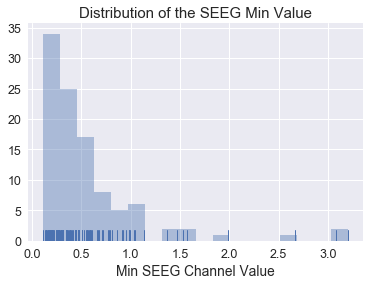

In [22]:
sigvals = []
for idx, sig in enumerate(seegts):
    sigvals.append(np.max(sig))

print(sigvals)
    
fig = plt.figure()
sns.set(font_scale=1.25)
sns.distplot(np.multiply(sigvals,500), kde=False, rug=True,
             axlabel='Min SEEG Channel Value')
plt.title('Distribution of the SEEG Min Value')
ax = plt.gca()
# ax.set_xticks(np.arange(0,60,5))

# Apply Visualization of The Data

In [37]:
brainplotter = tvbsim.visualize.plotbrain.VisualBrain()
brainplotter.setfigsize(figsize=(20,17))
brainplotter.loadsurf(maintvbexp.vertices)
brainplotter.loadseeg(maintvbexp.seeg_xyz, maintvbexp.seeg_labels)
brainplotter.loadregs(maintvbexp.conn.centres, maintvbexp.conn.region_labels)
brainplotter.setcontacts()

Nbre_contacts_per_electrode: [11, 11, 11, 11, 6, 13, 13, 12, 4, 11]
Nbre_electrodes: 10
Ending Index of electrodes: [ 11  22  33  44  50  63  76  88  92 103]


id008_gc
num regions:  84
num contacts:  103
10
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)


(<matplotlib.figure.Figure at 0x112e66a10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1634aae50>)

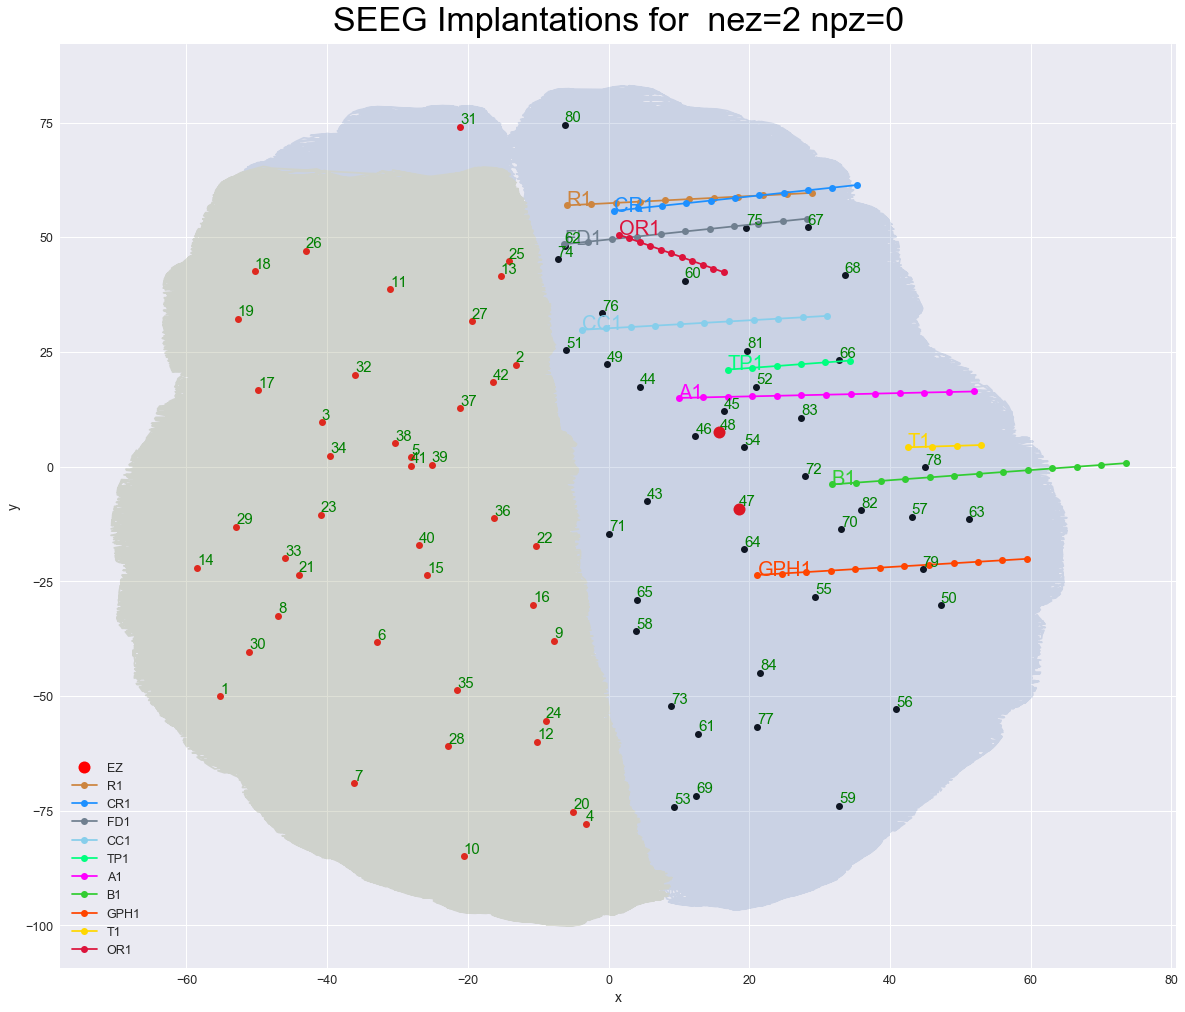

In [38]:
print(patient)
brainplotter.plotcontactsinbrain(maintvbexp.ezind, maintvbexp.pzind)

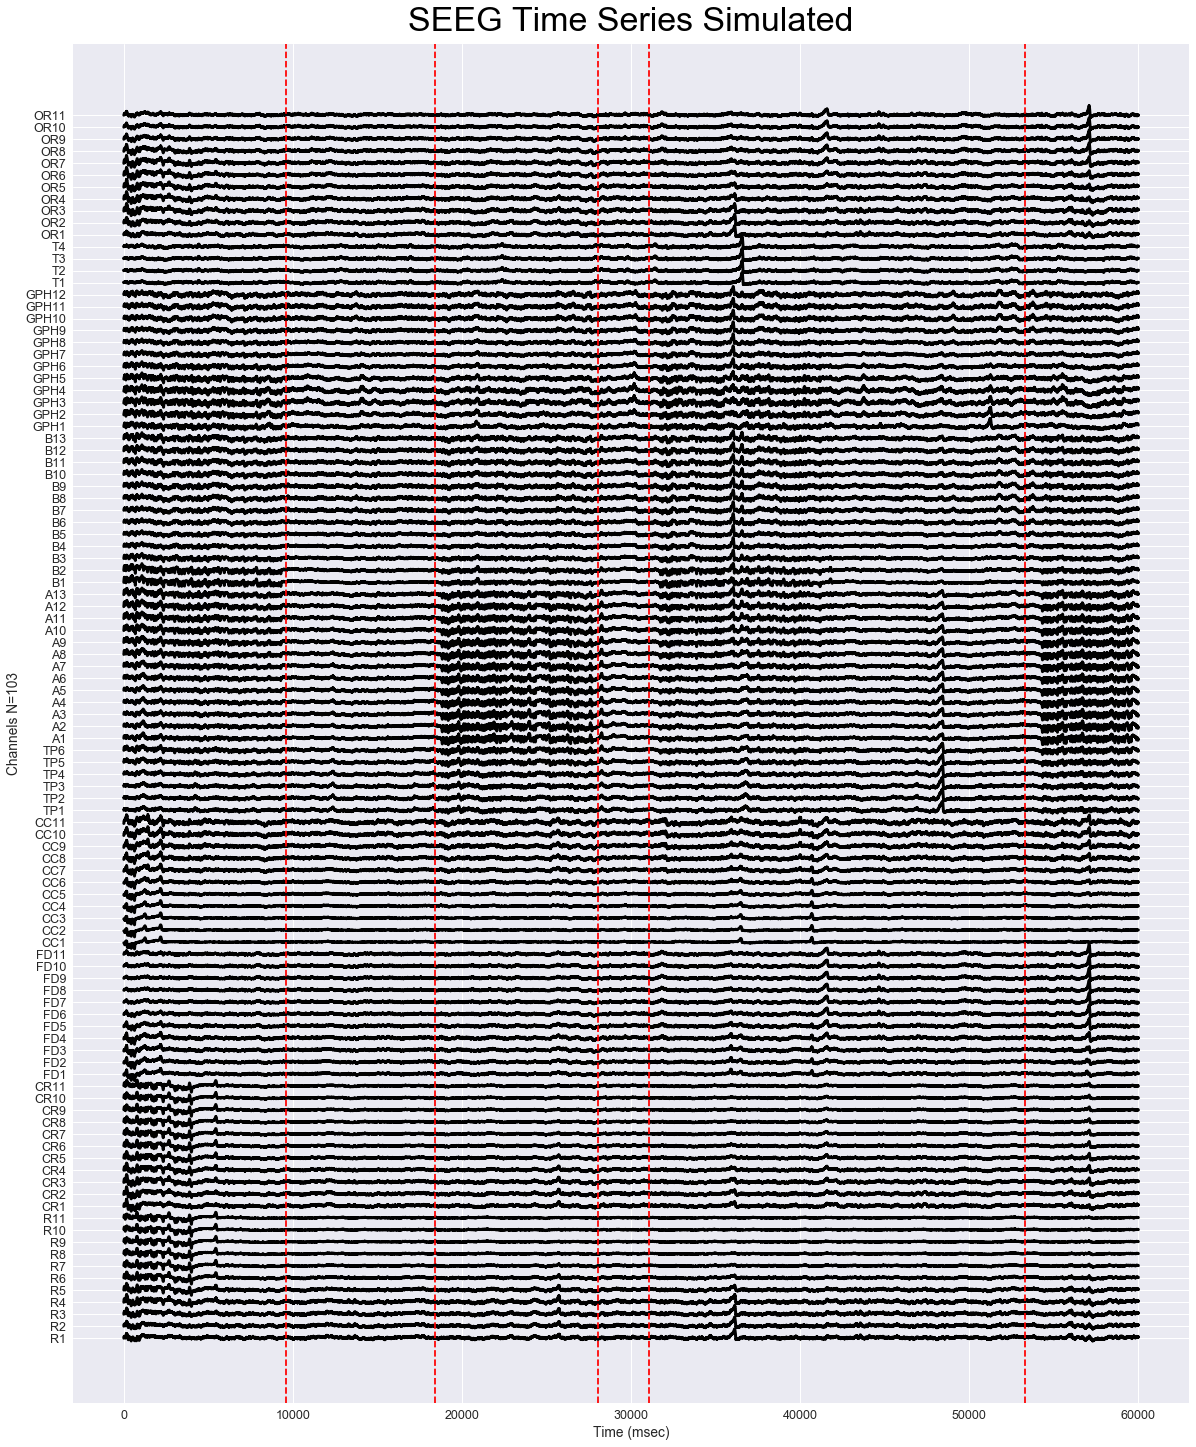

In [39]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=maintvbexp.seeg_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
# tsviz.colorts(maintvbexp.ezind, color=colors[0])

9.551828723233518e+18
(103, 103)


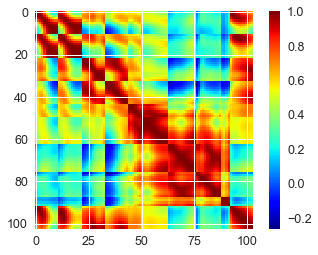

In [40]:
winsizems = 2500
corr = np.corrcoef(seegts[:, 0:winsizems])
# corr = np.cov(seegts[:, 0:winsizems])
print(np.linalg.cond(corr))
print(corr.shape)
plt.imshow(corr, cmap='jet')
plt.colorbar()

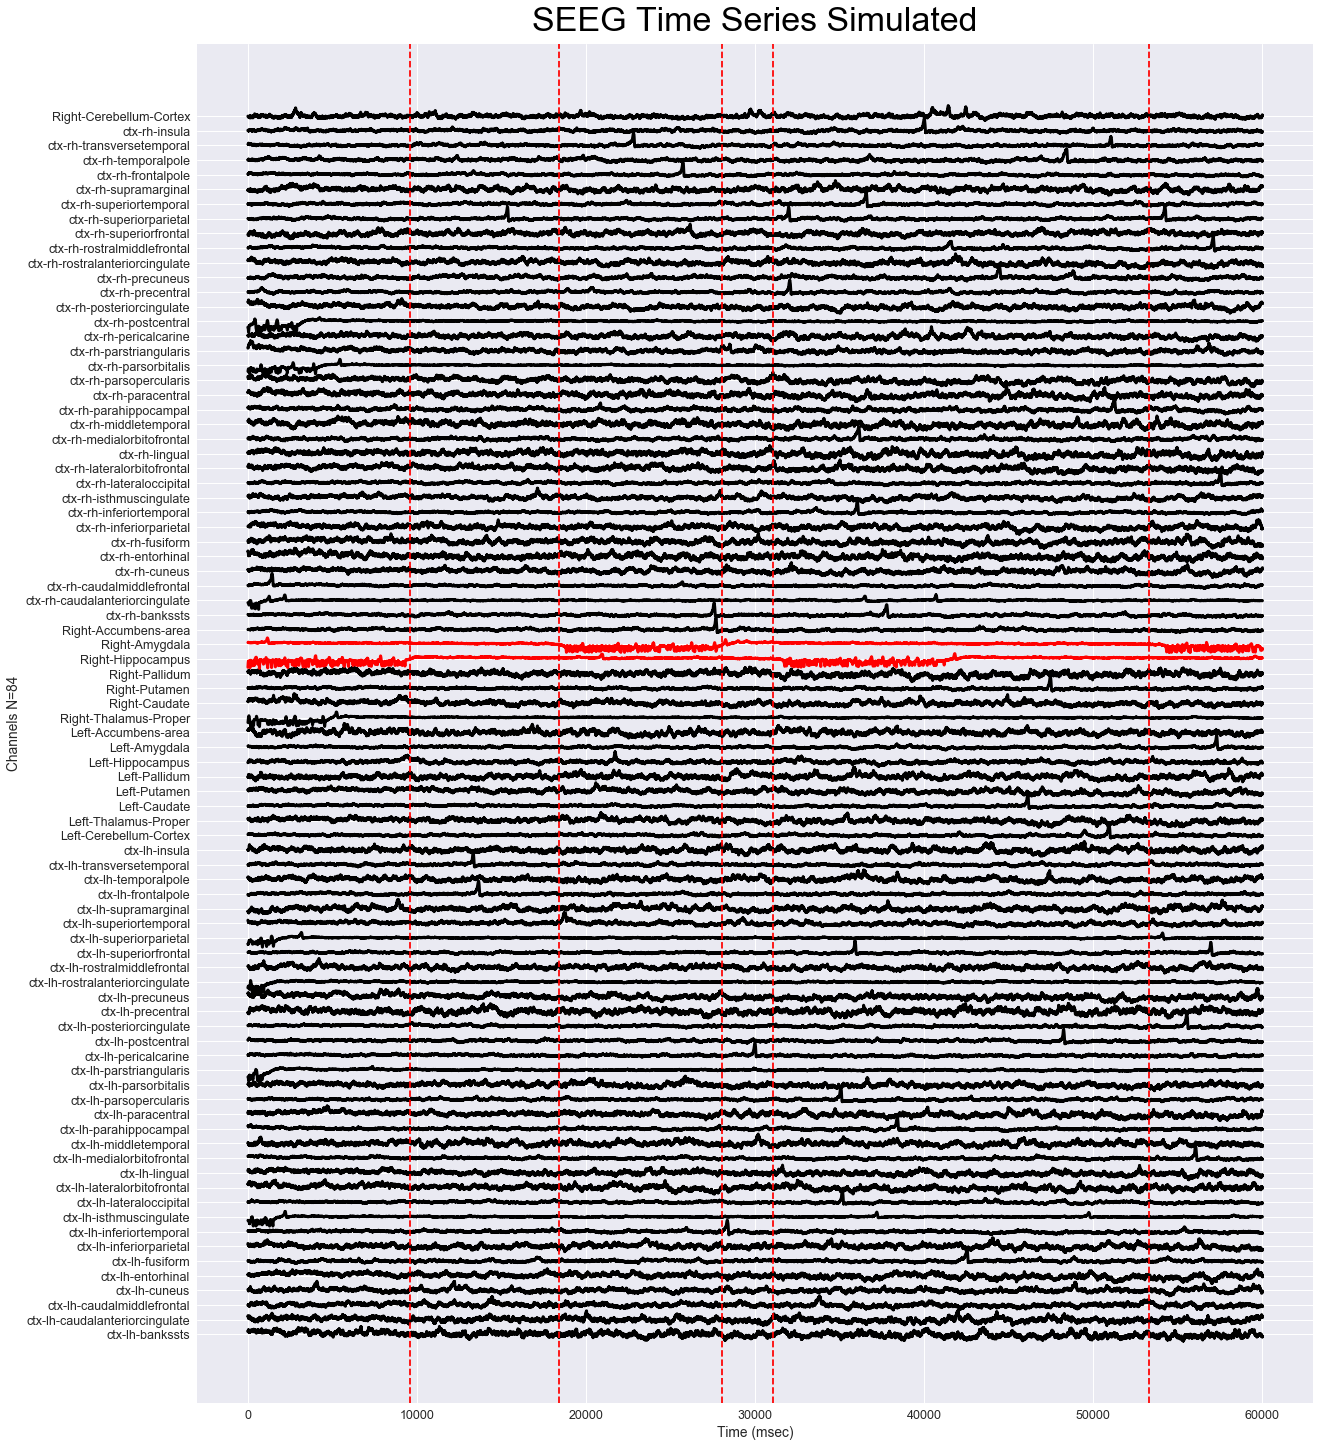

In [41]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=maintvbexp.conn.region_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(maintvbexp.ezind, color='red')

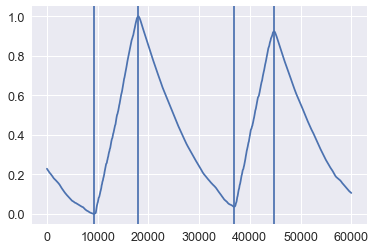

In [103]:
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()
# get the onsettimes and offsettimes for ez/pz indices
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.8)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

# print(settimes)
# test = 
# plt.plot(epits[maintvbexp.ezind[0],5000:25000])
plt.plot(scaler.fit_transform(zts[maintvbexp.ezind[0],:].reshape(-1, 1)))
for i in seizonsets:
    plt.axvline(i)
for i in seizoffsets:
    plt.axvline(i)
# plt.axhline(np.mean(scaler.fit_transform(zts[maintvbexp.ezind[0],:].reshape(-1, 1))))

In [94]:
for idx, delt in enumerate([0.2/4, 0.2, 0.6, 0.8]):
    settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=delt)# get the actual seizure times and offsets
    
    if idx == 0:
        allsettimes = settimes
    else:
        allsettimes = np.append(allsettimes, settimes, axis=0)

print(set(allsettimes))

TypeError: unhashable type: 'numpy.ndarray'

In [71]:
print(maintvbexp.conn.centres[maintvbexp.ezind])
for ind in maintvbexp.ezind:
    print(maintvbexp.findclosestcontact(ind))

[[ 41.72   -37.5433 -31.4786]]
(26, 14.507025155075729)


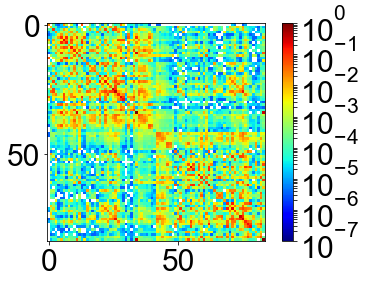

In [35]:
from matplotlib import colors, cm
plt.figure()
image = maintvbexp.conn.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])